**Image classification (hot dog/not hot dog)**



---




# Data

**Data Set Information:**

Binary classification
Images are splitted on 4 groups - train/test, hot dog/not hot dog
Metrics: Accuracy


# Imports

In [ ]:
%matplotlib inline

import numpy as np
import os
#import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.image as mpimg

import missingno as msno
#from pathlib import Path

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## TF

In [ ]:
!pip install update tensorflow
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
from zipfile import ZipFile

# Read data

In [ ]:
gdrive_url = '/content/gdrive'
drive.mount(gdrive_url)

mydrive_url = os.path.join(gdrive_url, 'MyDrive')
dataset_url = os.path.join(mydrive_url, 'datasets/hotdog__not_hotdog.zip')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
with ZipFile(dataset_url, 'r') as zObject:
  
    zObject.extractall(
        path="/content/")

zip_dir = '/content/'

In [ ]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'hotdog__not_hotdog')
print(base_dir)
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_hd_dir = os.path.join(train_dir, 'hot_dog')  # directory with our training cat pictures
train_nhd_dir = os.path.join(train_dir, 'not_hot_dog')  # directory with our training dog pictures
validation_hd_dir = os.path.join(validation_dir, 'hot_dog')  # directory with our validation cat pictures
validation_nhd_dir = os.path.join(validation_dir, 'not_hot_dog')  # directory with our validation dog pictures

num_hd_tr = len(os.listdir(train_hd_dir))
num_nhd_tr = len(os.listdir(train_nhd_dir))

num_hd_val = len(os.listdir(validation_hd_dir))
num_nhd_val = len(os.listdir(validation_nhd_dir))

total_train = num_hd_tr + num_nhd_tr
total_val = num_hd_val + num_nhd_val

print('total training hot dog images:', num_hd_tr)
print('total training non hot dog images:', num_nhd_tr)

print('total validation hot dog images:', num_hd_val)
print('total validation non hot dog images:', num_nhd_val)
print("---")
print("Total training images:", total_train)
print("Total validation images:", total_val)

/content/hotdog__not_hotdog
total training hot dog images: 249
total training non hot dog images: 249
total validation hot dog images: 250
total validation non hot dog images: 250
---
Total training images: 498
Total validation images: 500


We can see that amount of trainig data is tiny and will not divide validation set into validation and test set. This is not a best practice of course, because I'm using validation set for tuning of hyperparameters - learning rate and regularization. Only in the end I realized that I could use a data augmentation on the validation set to take some data for the test set, but I don't have any time left to retrain the models =(.  

## Make weight dirs 

In [ ]:
save_path = os.path.join(mydrive_url, 'NN3_HW')
# Check whether the specified path exists or not
isExist = os.path.exists(save_path)
if not isExist:

   os.makedirs(save_path)
   print("The new saving directory is created!")

# Funcs

In [ ]:
def plotImages(images_arr):
  """
  This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

  """
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
      ax.imshow(img)
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_hist(history, url=None):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(loss))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  if url:
    plt.savefig(url, dpi=300)
  plt.show()

# Raw data

## Preprocessing

I found out that this batch size gives more stable and fast results. I tried larger image shape but it took significantly longer to train.

In [ ]:
BATCH_SIZE = 128  # Number of training examples to process before updating our models variables # 8-64
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [ ]:
train_image_generator = tf.keras.preprocessing.image.\
  ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = tf.keras.preprocessing.image.\
  ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [ ]:
train_data_gen = train_image_generator\
    .flow_from_directory(batch_size=BATCH_SIZE,
                            directory=train_dir,
                            shuffle=True,
                            target_size=(IMG_SHAPE,IMG_SHAPE), 
                            class_mode='binary')

Found 498 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator\
    .flow_from_directory(batch_size=BATCH_SIZE,
                          directory=validation_dir,
                          shuffle=False,
                          target_size=(IMG_SHAPE, IMG_SHAPE), 
                          class_mode='binary')

Found 500 images belonging to 2 classes.


## Visualizing data

In [ ]:
sample_training_images, _ = next(train_data_gen) 

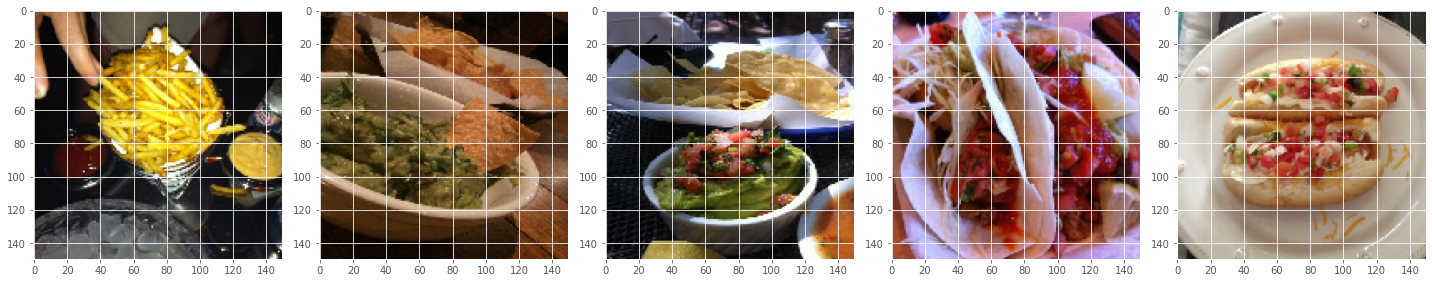

In [ ]:
plotImages(sample_training_images[:5])  # Plot images 0-4

## Model

I was going to try out: 
* batch norm and L2 decay
* cutout augmentation
* weight init 'Xavier'
* different learning rate scedules

but I didn't have time for cutout and tried only cosine lr decay schedule =(

In [ ]:
initializer = tf.keras.initializers.GlorotNormal()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                           input_shape=(IMG_SHAPE, IMG_SHAPE, 3), 
                           kernel_initializer=initializer),

    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', 
                           kernel_initializer=initializer),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           kernel_initializer=initializer),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           kernel_initializer=initializer),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_initializer=initializer),

    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_regularizer='l2',
                          kernel_initializer=initializer)
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                      

Despite being quite tiny this network has a lot of trainable parameters. We have a tiny amount of data and even with this tiny amount it takes quite a long time to train on a free TPU

## Callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=15)

## Learning

In [ ]:
EPOCHS = 50
BATCH_SIZE = 128  # Number of training examples to process before updating our models variables # 8-64

'''history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
#    callbacks = [early_stopping]
)'''

Epoch 1/50
4/4 [==============================] - 59s 15s/step - loss: 7.1283 - accuracy: 0.5261 - val_loss: 0.7199 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 56s 15s/step - loss: 1.3791 - accuracy: 0.5482 - val_loss: 0.7188 - val_accuracy: 0.5000
Epoch 3/50
4/4 [==============================] - 51s 14s/step - loss: 0.7654 - accuracy: 0.5843 - val_loss: 0.7027 - val_accuracy: 0.5240
Epoch 4/50
4/4 [==============================] - 56s 15s/step - loss: 0.6175 - accuracy: 0.6908 - val_loss: 0.7123 - val_accuracy: 0.5320
Epoch 5/50
4/4 [==============================] - 47s 12s/step - loss: 0.5818 - accuracy: 0.7229 - val_loss: 0.7308 - val_accuracy: 0.4820
Epoch 6/50
4/4 [==============================] - 55s 15s/step - loss: 0.5224 - accuracy: 0.7871 - val_loss: 0.7560 - val_accuracy: 0.4580
Epoch 7/50
4/4 [==============================] - 57s 16s/step - loss: 0.4602 - accuracy: 0.8173 - val_loss: 0.8235 - val_accuracy: 0.4940
Epoch 8/50
4/4 [===========

## Lerning curves

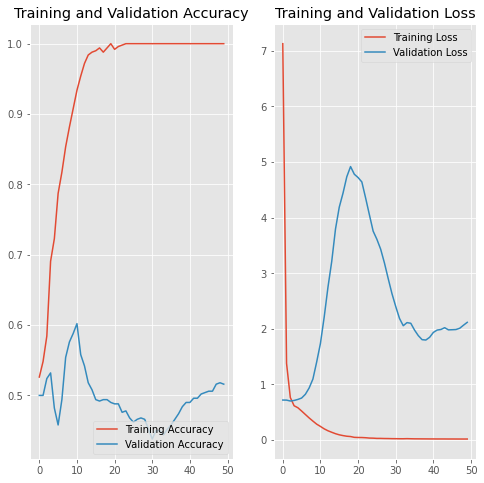

In [ ]:
learn_base = os.path.join(save_path, 'base_learn50.png')
if os.path.exists(learn_base):
  import matplotlib.image as mpimg
  img = mpimg.imread(learn_base)
  imgplot = plt.imshow(img)
  plt.show()
else:
  plot_hist(history=history, url=learn_base)

It starts to overfit terribly almost from the beginning despite L2 reg. Plus there is in general unrepresentative training set.

# With data augmentation

## Preprocessing

In [ ]:
BATCH_SIZE = 128
IMG_SHAPE  = 150 

I'm going to add cutout in case of time left:

In [ ]:
#!pip install cutout-random-erasing
#from cutout-random-erasing.random_eraser import get_random_eraser  # added

In [ ]:
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=360, 
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.3, 
    zoom_range=0.5, 
    horizontal_flip=True, 
    fill_mode='nearest')
    #preprocessing_function=get_random_eraser(v_l=0, v_h=1)))

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(IMG_SHAPE, IMG_SHAPE), 
    class_mode='binary')


Found 498 images belonging to 2 classes.


## Visualizing data

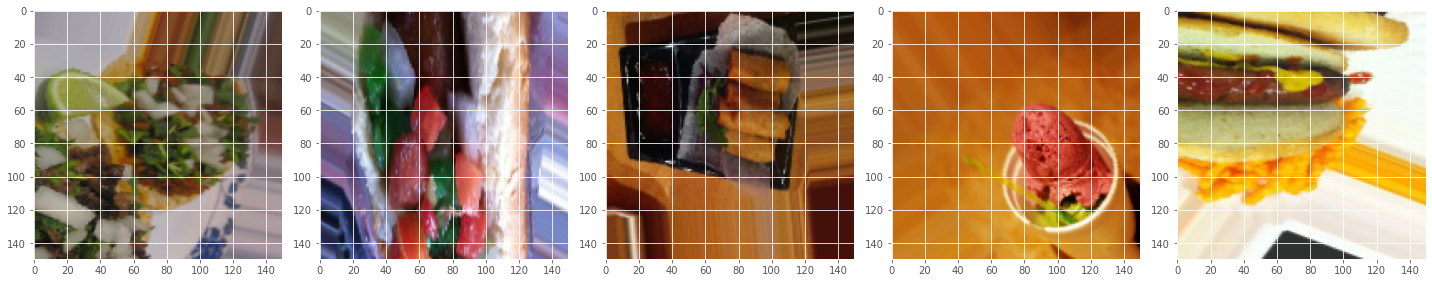

In [ ]:
sample_training_images, _ = next(train_data_gen) 
plotImages(sample_training_images[:5])  # Plot images 0-4

## Model

I tried different learning rates, Xiavier weights initialization,
nothing seems to improve much.  

In [ ]:
# Xavier weights init

initializer = tf.keras.initializers.GlorotNormal()

# Cosine learning rate decay

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_learning_rate, 
    decay_steps=10, 
    alpha=0.0, 
    name=None
)

# in the end constant lr works better when time is realy limited

opt = tf.keras.optimizers.Adam(learning_rate=0.005)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(IMG_SHAPE, IMG_SHAPE, 3),
                           kernel_initializer=initializer),

    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', 
                           kernel_initializer=initializer),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', 
                          kernel_initializer=initializer),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                           kernel_initializer=initializer),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer='l2',
                          kernel_initializer=initializer),

    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=initializer)
])

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 72, 72, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                      

## Load from checkpoint

I was trying to save model and load it later to continue training from the checkpoint, but it didn't work - you can see below after loading the model printout from the learning process starts with:

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.6281 - accuracy: 0.5904
Epoch 1: val_accuracy improved from -inf to 0.49400, saving model to /content/gdrive/MyDrive/NN3_HW/aug_new/cp-0001.ckpt

I don't understand why


In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = os.path.join(save_path, "aug/cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

ch_dir = checkpoint_dir + '/'

import glob
if os.path.exists(ch_dir):
  files = list(glob.glob(ch_dir + "*"))
  files.sort(key=lambda x: os.path.getmtime(x))

  print(f'the latest model found: {files[-1]}')

  model = tf.keras.models.load_model(files[-1])

  # Reset 
  val_data_gen.reset()

  # Evaluate on Validation data
  scores = model.evaluate(val_data_gen)
  print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

  #new checkpoint dir
  checkpoint_path = os.path.join(save_path, "aug_new/cp-{epoch:04d}.ckpt")
  checkpoint_dir = os.path.dirname(checkpoint_path)

the latest model found: /content/gdrive/MyDrive/NN3_HW/aug/cp-0033.ckpt
4/4 [==============================] - 13s 3s/step - loss: 0.7783 - accuracy: 0.6440
evaluate accuracy: 64.40%


## Callbacks

In [ ]:
# Create a callback that saves the model's weights

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    )


### Print learning rate


class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, batch, logs={}):
    lr = tf.keras.backend.eval(self.model.optimizer.lr)
    print('learning rate: ' + str(lr))

print_lr = PrintLR()
  


## Learning

In [ ]:
EPOCHS = 100

'''history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks = [cp_callback, print_lr]
)'''

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.6281 - accuracy: 0.5904
Epoch 1: val_accuracy improved from -inf to 0.49400, saving model to /content/gdrive/MyDrive/NN3_HW/aug_new/cp-0001.ckpt


learning rate: 0.005
4/4 [==============================] - 65s 13s/step - loss: 1.6281 - accuracy: 0.5904 - val_loss: 1.8190 - val_accuracy: 0.4940
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.5004 - accuracy: 0.6205
Epoch 2: val_accuracy improved from 0.49400 to 0.53400, saving model to /content/gdrive/MyDrive/NN3_HW/aug_new/cp-0002.ckpt


learning rate: 0.005
4/4 [==============================] - 60s 17s/step - loss: 1.5004 - accuracy: 0.6205 - val_loss: 1.6572 - val_accuracy: 0.5340
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.3940 - accuracy: 0.5803
Epoch 3: val_accuracy did not improve from 0.53400
learning rate: 0.005
4/4 [==============================] - 50s 13s/step - loss: 1.3940 - accuracy: 0.5803 - val_loss: 2.1278 - val_accuracy: 0.5040
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.3084 - accuracy: 0.6124
Epoch 4: val_accuracy did not improve from 0.53400
learning rate: 0.005
4/4 [==============================] - 65s 15s/step - loss: 1.3084 - accuracy: 0.6124 - val_loss: 2.3022 - val_accuracy: 0.5140
Epoch 5/100
4/4 [==============================] - ETA: 0s - loss: 1.1662 - accuracy: 0.6245
Epoch 5: val_accuracy did not improve from 0.53400
learning rate: 0.005
4/4 [==============================] - 58s 16s/step - loss: 1.1662 - accuracy: 0.6245 - val_loss: 3.

learning rate: 0.005
4/4 [==============================] - 53s 13s/step - loss: 1.1339 - accuracy: 0.6466 - val_loss: 1.2074 - val_accuracy: 0.5860
Epoch 7/100
4/4 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.6486
Epoch 7: val_accuracy did not improve from 0.58600
learning rate: 0.005
4/4 [==============================] - 58s 16s/step - loss: 1.0182 - accuracy: 0.6486 - val_loss: 1.7455 - val_accuracy: 0.5540
Epoch 8/100
4/4 [==============================] - ETA: 0s - loss: 0.9662 - accuracy: 0.6506
Epoch 8: val_accuracy did not improve from 0.58600
learning rate: 0.005
4/4 [==============================] - 58s 15s/step - loss: 0.9662 - accuracy: 0.6506 - val_loss: 2.1371 - val_accuracy: 0.4680
Epoch 9/100
4/4 [==============================] - ETA: 0s - loss: 0.9334 - accuracy: 0.6165
Epoch 9: val_accuracy did not improve from 0.58600
learning rate: 0.005
4/4 [==============================] - 59s 16s/step - loss: 0.9334 - accuracy: 0.6165 - val_loss: 1.

learning rate: 0.005
4/4 [==============================] - 52s 13s/step - loss: 0.6862 - accuracy: 0.7028 - val_loss: 0.8224 - val_accuracy: 0.5920
Epoch 27/100
4/4 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.6847
Epoch 27: val_accuracy did not improve from 0.59200
learning rate: 0.005
4/4 [==============================] - 49s 13s/step - loss: 0.7047 - accuracy: 0.6847 - val_loss: 0.8190 - val_accuracy: 0.4940
Epoch 28/100
4/4 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.7149
Epoch 28: val_accuracy did not improve from 0.59200
learning rate: 0.005
4/4 [==============================] - 59s 16s/step - loss: 0.6789 - accuracy: 0.7149 - val_loss: 0.8031 - val_accuracy: 0.5600
Epoch 29/100
4/4 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.7329
Epoch 29: val_accuracy did not improve from 0.59200
learning rate: 0.005
4/4 [==============================] - 50s 13s/step - loss: 0.6474 - accuracy: 0.7329 - val_lo

learning rate: 0.005
4/4 [==============================] - 61s 17s/step - loss: 0.7023 - accuracy: 0.7209 - val_loss: 0.7826 - val_accuracy: 0.6000
Epoch 37/100
4/4 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.7309
Epoch 37: val_accuracy did not improve from 0.60000
learning rate: 0.005
4/4 [==============================] - 58s 15s/step - loss: 0.6633 - accuracy: 0.7309 - val_loss: 0.8361 - val_accuracy: 0.5640
Epoch 38/100
4/4 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.7490
Epoch 38: val_accuracy did not improve from 0.60000
learning rate: 0.005
4/4 [==============================] - 58s 16s/step - loss: 0.6387 - accuracy: 0.7490 - val_loss: 0.8685 - val_accuracy: 0.5440
Epoch 39/100
4/4 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7289
Epoch 39: val_accuracy did not improve from 0.60000
learning rate: 0.005
4/4 [==============================] - 59s 16s/step - loss: 0.6586 - accuracy: 0.7289 - val_lo

learning rate: 0.005
4/4 [==============================] - 52s 14s/step - loss: 0.6414 - accuracy: 0.7390 - val_loss: 0.7454 - val_accuracy: 0.6500
Epoch 43/100
4/4 [==============================] - ETA: 0s - loss: 0.6081 - accuracy: 0.7530 
Epoch 43: val_accuracy did not improve from 0.65000
learning rate: 0.005
4/4 [==============================] - 58s 16s/step - loss: 0.6081 - accuracy: 0.7530 - val_loss: 1.0134 - val_accuracy: 0.5160
Epoch 44/100
4/4 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.7369
Epoch 44: val_accuracy did not improve from 0.65000
learning rate: 0.005
4/4 [==============================] - 56s 15s/step - loss: 0.6457 - accuracy: 0.7369 - val_loss: 0.8198 - val_accuracy: 0.5700
Epoch 45/100
4/4 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.7651 
Epoch 45: val_accuracy did not improve from 0.65000
learning rate: 0.005
4/4 [==============================] - 56s 15s/step - loss: 0.6196 - accuracy: 0.7651 - val_

learning rate: 0.005
4/4 [==============================] - 61s 17s/step - loss: 0.6062 - accuracy: 0.7590 - val_loss: 0.7954 - val_accuracy: 0.6580
Epoch 75/100
4/4 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7912
Epoch 75: val_accuracy did not improve from 0.65800
learning rate: 0.005
4/4 [==============================] - 58s 16s/step - loss: 0.5742 - accuracy: 0.7912 - val_loss: 0.8662 - val_accuracy: 0.6560
Epoch 76/100
4/4 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.7510
Epoch 76: val_accuracy did not improve from 0.65800
learning rate: 0.005
4/4 [==============================] - 58s 15s/step - loss: 0.5960 - accuracy: 0.7510 - val_loss: 0.8743 - val_accuracy: 0.6040
Epoch 77/100
4/4 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.7892
Epoch 77: val_accuracy did not improve from 0.65800
learning rate: 0.005
4/4 [==============================] - 49s 13s/step - loss: 0.5433 - accuracy: 0.7892 - val_lo

## Learning curves

In both cases even with augmentation we can see, that trining dataset is not representative and after 100 epochs it starts to overfit. 

### Without reg

Learing rate here was the default value: 0.001

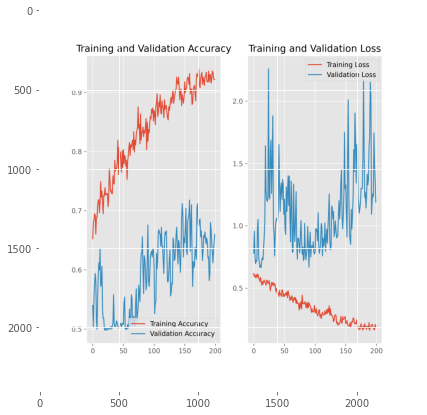

In [ ]:
learn_aug_noL2 = os.path.join(save_path, 'aug_learn200.png')
img = mpimg.imread(learn_aug_noL2)
imgplot = plt.imshow(img)
plt.show()

### With regularization:

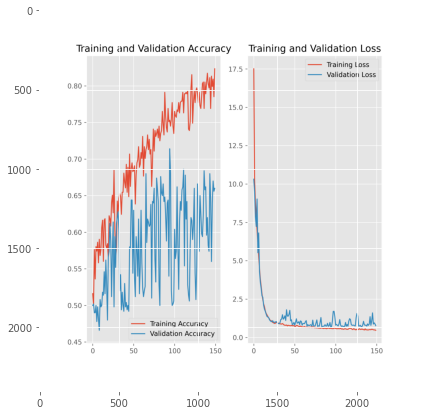

In [ ]:
learn_aug = os.path.join(save_path, 'aug_learn.png')
fresh = False

if os.path.exists(learn_aug) and not fresh:
  img = mpimg.imread(learn_aug)
  imgplot = plt.imshow(img)
  plt.show()
else:
  plot_hist(history=history, url=learn_aug)

We can see how regularization and increased learning rate made curves more 'right', but it doesn't help with the performance much

# Transfer Learning - Inception V3

## Preprocessing

In [ ]:
BATCH_SIZE = 128
IMG_SHAPE  = 150 

image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=360, 
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.3, 
    zoom_range=0.5, 
    horizontal_flip=True, 
    fill_mode='nearest')
    #preprocessing_function=get_random_eraser(v_l=0, v_h=1)))

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(IMG_SHAPE, IMG_SHAPE), 
    class_mode='binary')


## Base model

Keras has a wide ist list of available models and the first one I choose basically random - decent top 1 accuracy and not very large size and I like the name =))

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input_tensor = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

base_model = InceptionV3(
    input_tensor=input_tensor, 
    weights='imagenet', 
    include_top=True
    )

base_model.summary()

96112376/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 74, 74, 32)  96          ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                      

## New output

In [ ]:
# add a global spatial average pooling layer
x = base_model.layers[-2].output
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = tf.keras.layers.Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 74, 74, 32)  96          ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                            

## Learning

In [ ]:
EPOCHS = 10

'''history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
#    callbacks = [cp_callback]
)'''

'history = model.fit_generator(\n    train_data_gen,\n    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),\n    epochs=EPOCHS,\n    validation_data=val_data_gen,\n    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),\n#    callbacks = [cp_callback]\n)'

## Learning curves

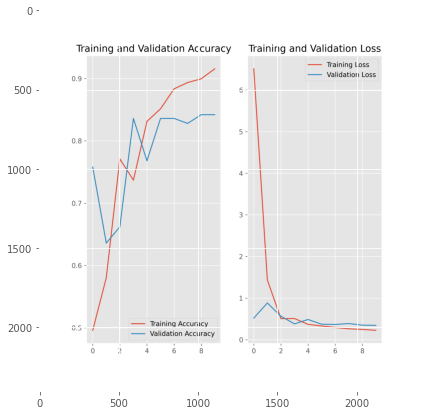

In [ ]:
learn_inc = os.path.join(save_path, 'inception_learn_1.png')
fresh = False

if os.path.exists(learn_inc) and not fresh:
  img = mpimg.imread(learn_inc)
  imgplot = plt.imshow(img)
  plt.show()
else:
  plot_hist(history=history, url=learn_inc)

That's already quite awesome results

## Fine tuning

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_20
2 batch_normalization_15
3 activation
4 conv2d_21
5 batch_normalization_16
6 activation_1
7 conv2d_22
8 batch_normalization_17
9 activation_2
10 max_pooling2d_20
11 conv2d_23
12 batch_normalization_18
13 activation_3
14 conv2d_24
15 batch_normalization_19
16 activation_4
17 max_pooling2d_21
18 conv2d_28
19 batch_normalization_23
20 activation_8
21 conv2d_26
22 conv2d_29
23 batch_normalization_21
24 batch_normalization_24
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_25
29 conv2d_27
30 conv2d_30
31 conv2d_31
32 batch_normalization_20
33 batch_normalization_22
34 batch_normalization_25
35 batch_normalization_26
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_35
42 batch_normalization_30
43 activation_15
44 conv2d_33
45 conv2d_36
46 batch_normalization_28
47 batch_normalization_31
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_32
52 conv2d_34
53 conv2d_37
54 conv2d_38
55 batch_normalization_27

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:299]:
   layer.trainable = False
for layer in model.layers[299:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


In [ ]:
EPOCHS = 150

'''history_fine = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
#    callbacks = [cp_callback]
)'''

Epoch 1/150
4/4 [==============================] - 78s 21s/step - loss: 0.9509 - accuracy: 0.4398 - val_loss: 0.9592 - val_accuracy: 0.4500
Epoch 2/150
4/4 [==============================] - 81s 24s/step - loss: 0.8929 - accuracy: 0.4779 - val_loss: 0.8579 - val_accuracy: 0.4560
Epoch 3/150
4/4 [==============================] - 70s 20s/step - loss: 0.8622 - accuracy: 0.4659 - val_loss: 0.8048 - val_accuracy: 0.4940
Epoch 4/150
4/4 [==============================] - 70s 21s/step - loss: 0.8155 - accuracy: 0.5000 - val_loss: 0.7729 - val_accuracy: 0.5500
Epoch 5/150
4/4 [==============================] - 59s 16s/step - loss: 0.7824 - accuracy: 0.5442 - val_loss: 0.7355 - val_accuracy: 0.5840
Epoch 6/150
4/4 [==============================] - 71s 20s/step - loss: 0.7558 - accuracy: 0.5361 - val_loss: 0.6943 - val_accuracy: 0.6080
Epoch 7/150
4/4 [==============================] - 72s 21s/step - loss: 0.7197 - accuracy: 0.5582 - val_loss: 0.6596 - val_accuracy: 0.6360
Epoch 8/150
4/4 [===

In [ ]:
#model.save(os.path.join(save_path, 'final_model'))

## Learning curves

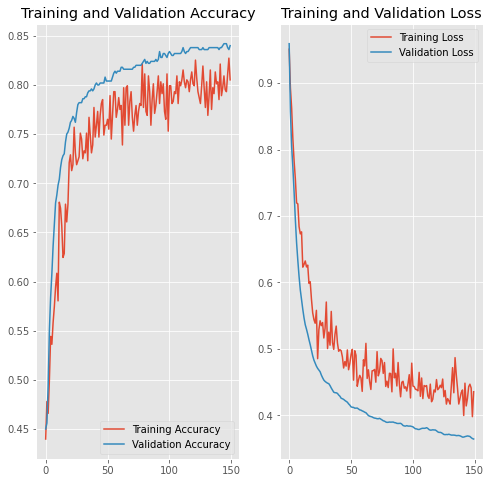

In [ ]:
learn_inc2 = os.path.join(save_path, 'inception_learn_2.png')
fresh = False

if os.path.exists(learn_inc2) and not fresh:
  img = mpimg.imread(learn_inc2)
  imgplot = plt.imshow(img)
  plt.show()
elif history_fine:
  plot_hist(history=history_fine, url=learn_inc2)

Looks like underfitting. I would loke to try increase number of dense layers and a learning rate a bit, but I'm running out of time already.

# Transfer Learning 2

I have tried few models but something is broken - they don't learn at all or learn very slowly =( I do not understand why - first time model worked out of the box with the same code. 

## Preprocessing

Without augmentation it should overfit pretty fast, but it does not

In [ ]:
BATCH_SIZE = 128
IMG_SHAPE  = 150 

image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, )
#    rotation_range=360, 
#    width_shift_range=0.3, 
#    height_shift_range=0.3, 
#    shear_range=0.3, 
#    zoom_range=0.5, 
#    horizontal_flip=True, 
#    fill_mode='nearest')
    #preprocessing_function=get_random_eraser(v_l=0, v_h=1)))

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(IMG_SHAPE, IMG_SHAPE), 
    class_mode='binary')

validation_image_generator = tf.keras.preprocessing.image.\
  ImageDataGenerator(rescale=1./255)  # Generator for our validation data

val_data_gen = validation_image_generator\
    .flow_from_directory(batch_size=BATCH_SIZE,
                          directory=validation_dir,
                          shuffle=False,
                          target_size=(IMG_SHAPE, IMG_SHAPE), 
                          class_mode='binary')

Found 498 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


## Base model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

input_tensor = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor, 
    )

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

## New output

In [ ]:
# add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(
    512, 
    activation='relu', 
    kernel_initializer='random_normal')(x)

predictions = tf.keras.layers.Dense(
    1, 
    activation='sigmoid', 
    kernel_initializer='random_normal')(x)

# this is the model we will train
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [ ]:
for layer in model.layers[:312]:
   layer.trainable = False
for layer in model.layers[312:]:
   layer.trainable = True

In [ ]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), 
    loss='binary_crossentropy', 
    metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

We can see that the trainable part is exactly two last layers

## Learning

I do not understand why it learns so slowl, I tried to increase lr, but it stopped learning all together

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5)

EPOCHS = 50

history_effnet = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
    callbacks = []
)

Epoch 1/50
4/4 [==============================] - 262s 72s/step - loss: 0.9316 - accuracy: 0.5361 - val_loss: 1.1412 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 263s 80s/step - loss: 0.8577 - accuracy: 0.5321 - val_loss: 0.8690 - val_accuracy: 0.5000
Epoch 3/50
4/4 [==============================] - 240s 72s/step - loss: 0.8450 - accuracy: 0.5000 - val_loss: 0.6864 - val_accuracy: 0.5240
Epoch 4/50
4/4 [==============================] - 194s 56s/step - loss: 0.7418 - accuracy: 0.5422 - val_loss: 0.7619 - val_accuracy: 0.5000
Epoch 5/50
4/4 [==============================] - 237s 71s/step - loss: 0.7099 - accuracy: 0.5181 - val_loss: 0.7361 - val_accuracy: 0.5000
Epoch 6/50
4/4 [==============================] - 239s 73s/step - loss: 0.7156 - accuracy: 0.5060 - val_loss: 0.6749 - val_accuracy: 0.5840
Epoch 7/50
4/4 [==============================] - 238s 71s/step - loss: 0.6960 - accuracy: 0.5382 - val_loss: 0.6870 - val_accuracy: 0.5580
Epoch 8/50
4/4 [====

In [ ]:
model.save(os.path.join(save_path, 'final_model2'))

In [ ]:
import pickle
with open(os.path.join(save_path, 'history_effnet.pickle'), 'wb') as f:
    pickle.dump(history_effnet, f)    

## Learning curves

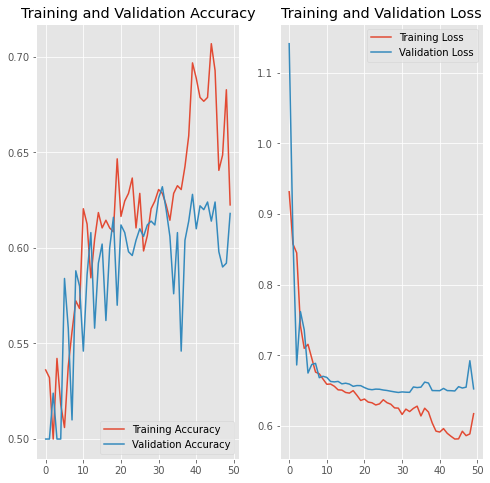

In [33]:
learn_effnet = os.path.join(save_path, 'effnet_learn.png')
fresh = True

if os.path.exists(learn_effnet) and not fresh:
  img = mpimg.imread(learn_effnet)
  imgplot = plt.imshow(img)
  plt.show()
elif history_effnet:
  plot_hist(history=history_effnet, url=learn_effnet)

# Conclusion

Keras is very conviniet framework to learn NN, but I have no idea why pre-trained models work at random. I just don't have time to sort this out. Also run them on free TPU takes ages and save and restart the train process from the checkpoint doesn't work as intended, and I have unstable internet connection. I will try to use pytorch next time, I hope checkpoints there will work better. 